Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (18724, 28, 28) (18724,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (18724, 784) (18724, 10)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [7]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
    
  # regularization parameter
  tf_beta = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + tf_beta * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [9]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 20.513441
Minibatch accuracy: 7.0%
Validation accuracy: 16.8%
Minibatch loss at step 500: 2.659864
Minibatch accuracy: 73.4%
Validation accuracy: 72.2%
Minibatch loss at step 1000: 1.689404
Minibatch accuracy: 75.0%
Validation accuracy: 74.9%
Minibatch loss at step 1500: 1.042121
Minibatch accuracy: 81.2%
Validation accuracy: 76.8%
Minibatch loss at step 2000: 0.907482
Minibatch accuracy: 79.7%
Validation accuracy: 77.9%
Minibatch loss at step 2500: 0.863228
Minibatch accuracy: 81.2%
Validation accuracy: 78.5%
Minibatch loss at step 3000: 1.147194
Minibatch accuracy: 71.1%
Validation accuracy: 77.9%
Test accuracy: 83.3%


In [10]:
num_steps = 3001

beta_vals = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_vals = []

for beta_val in beta_vals:
    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta : beta_val}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

      accuracy_vals.append(accuracy(test_prediction.eval(), test_labels))

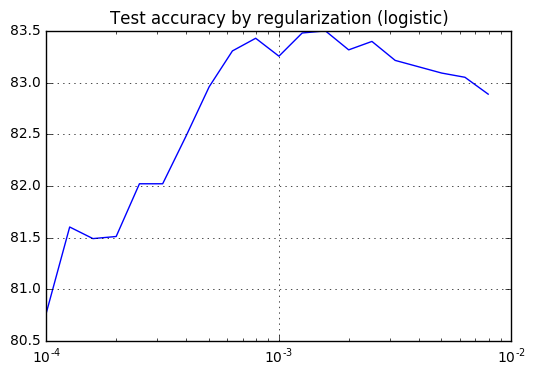

In [11]:
import matplotlib.pyplot as plt

plt.semilogx(beta_vals, accuracy_vals)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

In [12]:
n_input = image_size * image_size
n_hidden = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
    
  # regularization parameter
  tf_beta = tf.placeholder(tf.float32)
  
  # Variables.
  weights = {
    'h': tf.Variable(tf.truncated_normal([n_input, n_hidden])),
    'out': tf.Variable(tf.truncated_normal([n_hidden, num_labels]))
  }
  biases = {
    'h': tf.Variable(tf.zeros([n_hidden])),
    'out': tf.Variable(tf.zeros([num_labels]))
  }
  
  # Training computation.
  activ1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights['h']) + biases['h'])
  logits = tf.matmul(activ1, weights['out']) + biases['out']
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
    tf_beta * (tf.nn.l2_loss(weights['h']) + tf.nn.l2_loss(weights['out']))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights['h']) + biases['h']),
             weights['out']) + biases['out'])
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights['h']) + biases['h']),
             weights['out']) + biases['out'])

In [13]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 645.950195
Minibatch accuracy: 14.1%
Validation accuracy: 23.7%
Minibatch loss at step 500: 194.122925
Minibatch accuracy: 80.5%
Validation accuracy: 77.9%
Minibatch loss at step 1000: 113.928192
Minibatch accuracy: 82.0%
Validation accuracy: 78.2%
Minibatch loss at step 1500: 68.173462
Minibatch accuracy: 89.1%
Validation accuracy: 80.5%
Minibatch loss at step 2000: 42.600380
Minibatch accuracy: 78.9%
Validation accuracy: 80.7%
Minibatch loss at step 2500: 25.303392
Minibatch accuracy: 85.9%
Validation accuracy: 83.4%
Minibatch loss at step 3000: 15.704386
Minibatch accuracy: 81.2%
Validation accuracy: 84.4%
Test accuracy: 89.3%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [14]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = step % num_batches
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 10 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 641.647705
Minibatch accuracy: 9.4%
Validation accuracy: 23.2%
Minibatch loss at step 10: 311.368805
Minibatch accuracy: 100.0%
Validation accuracy: 63.1%
Minibatch loss at step 20: 308.267944
Minibatch accuracy: 100.0%
Validation accuracy: 63.2%
Minibatch loss at step 30: 305.200378
Minibatch accuracy: 100.0%
Validation accuracy: 63.2%
Minibatch loss at step 40: 302.163422
Minibatch accuracy: 100.0%
Validation accuracy: 63.2%
Minibatch loss at step 50: 299.156036
Minibatch accuracy: 100.0%
Validation accuracy: 63.2%
Minibatch loss at step 60: 296.178802
Minibatch accuracy: 100.0%
Validation accuracy: 63.2%
Minibatch loss at step 70: 293.231415
Minibatch accuracy: 100.0%
Validation accuracy: 63.2%
Minibatch loss at step 80: 290.311920
Minibatch accuracy: 100.0%
Validation accuracy: 63.2%
Minibatch loss at step 90: 287.423157
Minibatch accuracy: 100.0%
Validation accuracy: 63.2%
Minibatch loss at step 100: 284.562775
Minibatch accuracy: 100.0%
Valid

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [25]:
n_input = image_size * image_size
n_hidden = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # dropout probability
  tf_keep_prob = tf.placeholder(tf.float32)
    
  # Variables.
  weights = {
    'h': tf.Variable(tf.truncated_normal([n_input, n_hidden])),
    'out': tf.Variable(tf.truncated_normal([n_hidden, num_labels]))
  }
  biases = {
    'h': tf.Variable(tf.zeros([n_hidden])),
    'out': tf.Variable(tf.zeros([num_labels]))
  }
    
  # Training computation.
  activ = tf.nn.relu(tf.matmul(tf_train_dataset, weights['h']) + biases['h'])
  drop = tf.nn.dropout(activ, tf_keep_prob)

  logits = tf.matmul(drop, weights['out']) + biases['out']
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights['h']) + biases['h']),
             weights['out']) + biases['out'])
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights['h']) + biases['h']),
             weights['out']) + biases['out'])

In [26]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = step % num_batches
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_keep_prob : 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 10 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 462.473816
Minibatch accuracy: 6.2%
Validation accuracy: 32.6%
Minibatch loss at step 10: 6.766976
Minibatch accuracy: 96.9%
Validation accuracy: 65.0%
Minibatch loss at step 20: 0.667100
Minibatch accuracy: 99.2%
Validation accuracy: 66.9%
Minibatch loss at step 30: 0.000007
Minibatch accuracy: 100.0%
Validation accuracy: 67.4%
Minibatch loss at step 40: 2.408754
Minibatch accuracy: 99.2%
Validation accuracy: 66.7%
Minibatch loss at step 50: 0.233007
Minibatch accuracy: 99.2%
Validation accuracy: 67.9%
Minibatch loss at step 60: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 67.9%
Minibatch loss at step 70: 0.355141
Minibatch accuracy: 98.4%
Validation accuracy: 68.0%
Minibatch loss at step 80: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 67.9%
Minibatch loss at step 90: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 67.2%
Minibatch loss at step 100: 0.420271
Minibatch accuracy: 99.2%
Validation accuracy: 67.6%
Test

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [8]:
n_input = image_size * image_size

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # dropout probability
  tf_keep_prob = tf.placeholder(tf.float32)

  # learning_rate
  global_step = tf.Variable(0)  # count the number of steps taken.
  tf_starter_learning_rate = tf.placeholder(tf.float32)
  tf_decay_steps = tf.placeholder(tf.float32)
  learning_rate = tf.train.exponential_decay(tf_starter_learning_rate,
                                             global_step, tf_decay_steps, 0.99999, staircase=True)
    
  # Variables.
  n_hidden = {
    'h1': 1024,
    'h2': 512,
    'h3': 512,
    'h4': 256
  }

  weights = {
    'h1': tf.Variable(tf.truncated_normal([n_input, n_hidden['h1']],
                                         stddev=np.sqrt(2.0 / n_input))),
    'h2': tf.Variable(tf.truncated_normal([n_hidden['h1'], n_hidden['h2']],
                                         stddev=np.sqrt(2.0 / n_hidden['h1']))),
    'h3': tf.Variable(tf.truncated_normal([n_hidden['h2'], n_hidden['h3']],
                                         stddev=np.sqrt(2.0 / n_hidden['h2']))),
    'h4': tf.Variable(tf.truncated_normal([n_hidden['h3'], n_hidden['h4']],
                                         stddev=np.sqrt(2.0 / n_hidden['h3']))),
    'out': tf.Variable(tf.truncated_normal([n_hidden['h4'], num_labels],
                                         stddev=np.sqrt(2.0 / n_hidden['h4'])))
  }
  biases = {
    'h1': tf.Variable(tf.zeros([n_hidden['h1']])),
    'h2': tf.Variable(tf.zeros([n_hidden['h2']])),
    'h3': tf.Variable(tf.zeros([n_hidden['h3']])),
    'h4': tf.Variable(tf.zeros([n_hidden['h4']])),
    'out': tf.Variable(tf.zeros([num_labels]))
  }
    
  # Training computation.
  activ1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights['h1']) + biases['h1'])
  drop1 = tf.nn.dropout(activ1, tf_keep_prob)
      
  activ2 = tf.nn.relu(tf.matmul(drop1, weights['h2']) + biases['h2'])
  drop2 = tf.nn.dropout(activ2, tf_keep_prob)
    
  activ3 = tf.nn.relu(tf.matmul(drop2, weights['h3']) + biases['h3'])
  drop3 = tf.nn.dropout(activ3, tf_keep_prob)
    
  activ4 = tf.nn.relu(tf.matmul(drop3, weights['h4']) + biases['h4'])
  drop4 = tf.nn.dropout(activ4, tf_keep_prob)
    
  logits = tf.matmul(drop4, weights['out']) + biases['out']

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  #optimizer = tf.train.GradientDescentOptimizer(tf_starter_learning_rate).minimize(loss)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.AdamOptimizer(tf_starter_learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  valid_activ1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights['h1']) + biases['h1'])
  valid_activ2 = tf.nn.relu(tf.matmul(valid_activ1, weights['h2']) + biases['h2'])
  valid_activ3 = tf.nn.relu(tf.matmul(valid_activ2, weights['h3']) + biases['h3'])
  valid_activ4 = tf.nn.relu(tf.matmul(valid_activ3, weights['h4']) + biases['h4'])
    
  valid_prediction = tf.nn.softmax(tf.matmul(valid_activ4, weights['out']) + biases['out'])

  test_activ1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights['h1']) + biases['h1'])
  test_activ2 = tf.nn.relu(tf.matmul(test_activ1, weights['h2']) + biases['h2'])
  test_activ3 = tf.nn.relu(tf.matmul(test_activ2, weights['h3']) + biases['h3'])
  test_activ4 = tf.nn.relu(tf.matmul(test_activ3, weights['h4']) + biases['h4'])

  test_prediction = tf.nn.softmax(tf.matmul(test_activ4, weights['out']) + biases['out'])

In [9]:
num_steps = 150001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,
                 tf_keep_prob : .5, tf_starter_learning_rate : 0.1, tf_decay_steps: 1}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.960402
Minibatch accuracy: 14.1%
Validation accuracy: 11.3%
Minibatch loss at step 500: 0.527599
Minibatch accuracy: 81.2%
Validation accuracy: 83.2%
Minibatch loss at step 1000: 0.791469
Minibatch accuracy: 72.7%
Validation accuracy: 84.6%
Minibatch loss at step 1500: 0.584694
Minibatch accuracy: 85.9%
Validation accuracy: 85.1%
Minibatch loss at step 2000: 0.553001
Minibatch accuracy: 82.0%
Validation accuracy: 85.5%
Minibatch loss at step 2500: 0.653467
Minibatch accuracy: 84.4%
Validation accuracy: 86.0%
Minibatch loss at step 3000: 0.603536
Minibatch accuracy: 78.1%
Validation accuracy: 86.2%
Minibatch loss at step 3500: 0.533797
Minibatch accuracy: 85.2%
Validation accuracy: 86.7%
Minibatch loss at step 4000: 0.440643
Minibatch accuracy: 85.2%
Validation accuracy: 86.9%
Minibatch loss at step 4500: 0.466943
Minibatch accuracy: 85.9%
Validation accuracy: 87.2%
Minibatch loss at step 5000: 0.447857
Minibatch accuracy: 85.9%
Validation accurac